# 3G3 Lab: Coding in Visual Cortex

In this lab, you will explore sparse coding as a model of neural coding in the primary visual cortex (V1), and contrast it with principle component analysis.

## 0. Getting started

You can either run this notebook locally on your own machine or with Google Colab, with a Google account. 

To run the notebook locally, you should first clone this [GitHub repository](https://github.com/ghennequin/3g3lab). To do so, follow these [instructions](https://ghennequin.github.io/3g3lab/). 

By default we will assume that you are running it locally and you can ignore the instructions in the rest of this cell. Otherwise, **(1) choose File→Save a copy in Drive and follow the resulting prompts to save a copy in your Google Drive and (2) change `mode` in the next cell from `"local"` to `"colab"`.**<br/>

**Then, once in your own copy of the Colab notebook, go to the View menu on top of the page, and click on `Expand sections` first so you do not miss any hidden sections.**

After saving the modified Colab notebook, you should be able to access it inside the folder "Colab Notebooks" in Google Drive.
The saved Colab notebook will be called "Copy of 3g3lab.ipynb" by default. You can change the name at the top of the Colab notebook, as in standard Jupyter notebooks.

In [2]:
mode = "local" # change to "colab" if using Google Colab

## 1. The data structure

In general we will deal with a set of images, subimages sampled from those
images, a set of bases for the neurons, and the activations of the neurons.
For simplicity in this lab all images will be greyscale and square. Our notation and the data
formats are as follows. 

**Notational conventions** We use lowercase, bold
letters (e.g. $\mathbf{v}$) to denote vectors, and capital, bold letters (e.g. $\mathbf{M}$) to
denote matrices. When denoting vector or matrix components, e.g. $M_{ij}$, we drop the boldface. Typewriter font (e.g. `this`) is used to denote
Python/NumPy variables or functions. When we refer to the variables in the code, "vector" and "matrix" mean one- or two-dimensional NumPy arrays. 


**Images** We could code each image as a separate square matrix with
entries representing grey levels, but for efficiency we will code each image as
a vector by "flattening" the matrix, i.e. by concatenating all the rows. Then
*all* the images can be stored in a single matrix $\mathbf{I}$ where each row
represents a different image. The number of images thus equals the number
of rows in $\mathbf{I}$, while the number of columsn in $\mathbf{I}$  equals the number of pixels 
in the image, $N_{\sf pix}$.

**Subimages (aka image patches)** We will not work on the full images as they can be too
large for the simulations. We extract smaller square regions (or "subimages")
at random locations in the big images. A subimage $\mathbf{s}$ is again
flattened and represented by a (row) vector. The subimage matrix, $\mathbf{S}$, is in the same format as
the matrix of big images, i.e. uses one row per subimage. The number of
columns is the number of pixels in each subimage, and the number of rows is the
number of subimages. Assuming that all subimages have the same number of pixels, $n_{\sf pix}$, then the
size of $\mathbf{S}$ is thus $n_{\sf sub} \times n_{\sf pix}$; or in NumPy jargon, its "shape" is $(n_{\sf sub}, n_{\sf pix})$.

**Basis functions** the receptive fields $\phi_i$ are stored in a
matrix $\mathbf{B}$, in which the $i$-th row is the flattened version of the basis function $\phi_i$.
The number of columns in $\mathbf{B}$ is the number of pixels in each basis function, which we take to be 
the same as the number of pixels in each subimage, $n_{\sf pix}$. The number of
rows is the number of basis functions, that is the number of units in the V1 encoding, or more simply yet, the number of V1 model neurons.
Thus, the size of $\mathbf{B}$ is $n_{\sf bas} \times n_{\sf pix}$.

**Activations** The neural activations for a subimage are specified by a row
vector $\mathbf{a}$. The activations over a set of multiple subimages are
stored in matrix $\mathbf{A}$, with column $j$ corresponding to neuron $j$ (and thus associated with basis
function $\phi_j$) and row $i$ corresponding to the $i^{\sf th}$ subimage.

This representation allows simple matrix multiplication to calculate the
reconstructed images: $\widehat{\mathbf{s}} = \mathbf{aB}$ and $\widehat{\mathbf{S}} =
\mathbf{AB}$.

| notation     | meaning   |     NumPy shape   |
|:---------|:-----------:|:----------------:|
| $\mathbf{I}$ | matrix whose rows are the (flattened) full images | `(n_img,n_pix)` |
| $\mathbf{S}$ | matrix whose rows are the (flattened) subimages (or "image patches") | `(n_sub,n_pix)` |
| $\mathbf{A}$ | matrix whose rows are the neuronal activations for each subimage |  `(n_sub,n_bas)` |
| $\mathbf{B}$ | matrix whose rows are the (flattened) basis functions |  `(n_bas,n_pix)` |
| $n_{\sf pix}$ | number of pixels in a subimage / basis function | --- |
| $n_{\sf sub}$ | number of subimages | --- |
| $n_{\sf bas}$ | number of basis functions (number of "V1 neurons") | --- |






## 2. Getting started with Python/Numpy

Most students will be familiar with Python from the [IA computing course](http://teaching.eng.cam.ac.uk/content/engineering-tripos-part-ia-1p4-computing-2020-21).
**If you have not used Python/NumPy before, it should be possible
to get through the experiment with a help from a demonstrator, but you must work
through a tutorial on NumPy (and Python). We suggest the official [Quickstart Tutorial of NumPy](https://numpy.org/doc/stable/user/quickstart.html) or [this one](https://cs231n.github.io/python-numpy-tutorial/) which also captures the basics of Python, Matplotlib (the main Python module for plotting), Jupyter and Google Colab notebooks.**


To load the necessary Python modules run the next cell (you can run a cell by `Ctrl+Enter`
while you are in it; alternatively `Shift+Enter` runs the cell and proceeds to the next one).
Note that `lab` is a custom module written for this notebook. It's documentation can be found [here](https://ghennequin.github.io/3g3lab/).

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
matplotlib.rc('image', cmap='gray')

if mode == "local":
    import lab
elif mode == "colab":
    import requests
    url = 'https://github.com/ghennequin/3g3lab/blob/master/lab.py?raw=true'
    r = requests.get(url)
    with open('lab.py', 'w') as f:
        f.write(r.text)
    import lab
else:
    raise Exception("mode must be either local or colab")

## 3. Displaying images (10 min)

Three greyscale image sets are provided. To load the images, run the next cell.<br /> (For the Python novice: if you are curious to see the code for the functions from the module `lab`, such as `lab.load_data` in the next cell, open the file `lab.py`. To simply get help on their usage, you can more conveniently run, e.g., `lab.load_data?` in a notebook cell here. Or check this [documentation page](https://ghennequin.github.io/3g3lab/).)

In [4]:
imgs = lab.load_data(mode)

This will have loaded the image sets as a Python dictionary, `imgs`, with the following items (key-value pairs):


|    key     |  (description of) value |
|:----------|:-----------|
|`"I1"` |  one $512\times 512$ image stored as a $1 \times 262144$ matrix |
| `"I2"` |  nine $512\times 512$ image stored as a $9 \times 262144$ matrix |
`"I2w"` |  modified version of `imgs["I2"]`, discussed later|
`"I3"` |  nine $512\times 512$ image stored as a $9 \times 262144$ matrix|

Some are artificially generated images and some are images of real world
scenes. 

You can use the `lab.plot_all_images` function (defined in the previous cell) to view the images. For example, to display
*all* the images in set `imgs["I3"]` you can run

`lab.plot_all_images(imgs["I3"])`

which will display the images in the `I3` matrix (hereinafter we will use the shorthand `I3` to refer to `imgs["I3"]`, etc, in the text). To display only the first `n` images in `I3`, you can run `lab.plot_all_images(imgs["I3"][0:n])`, instead. 

Use the next cell to display each of
the images in the datasets `I1`, `I2`, `I2w` and `I3`. 

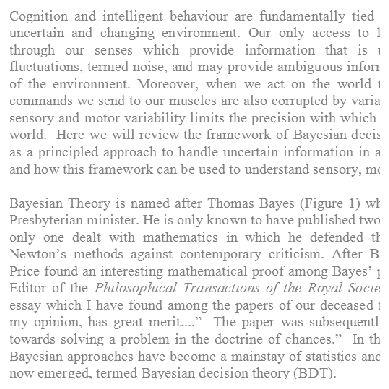

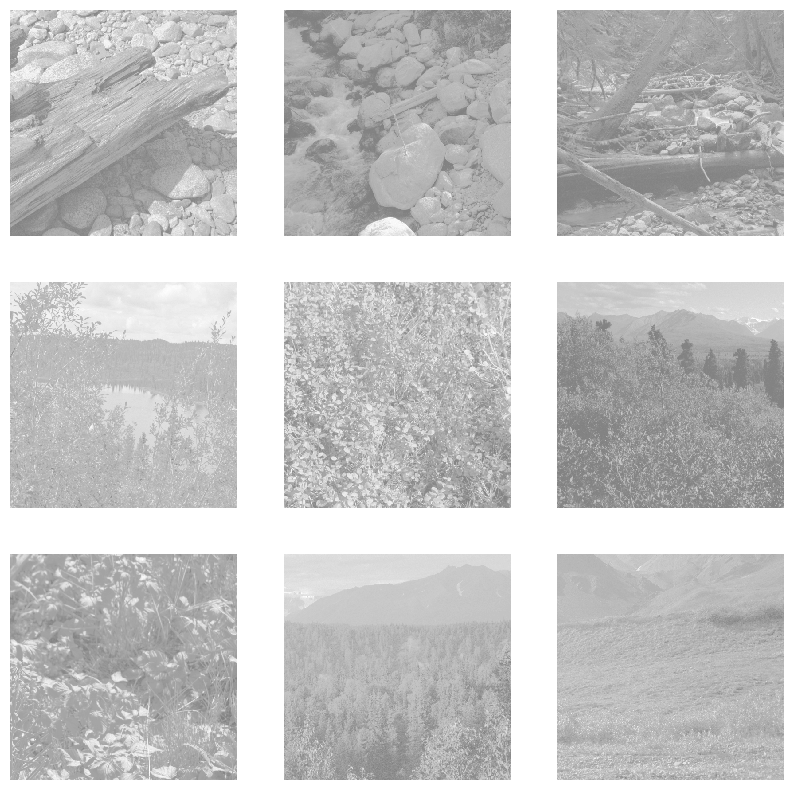

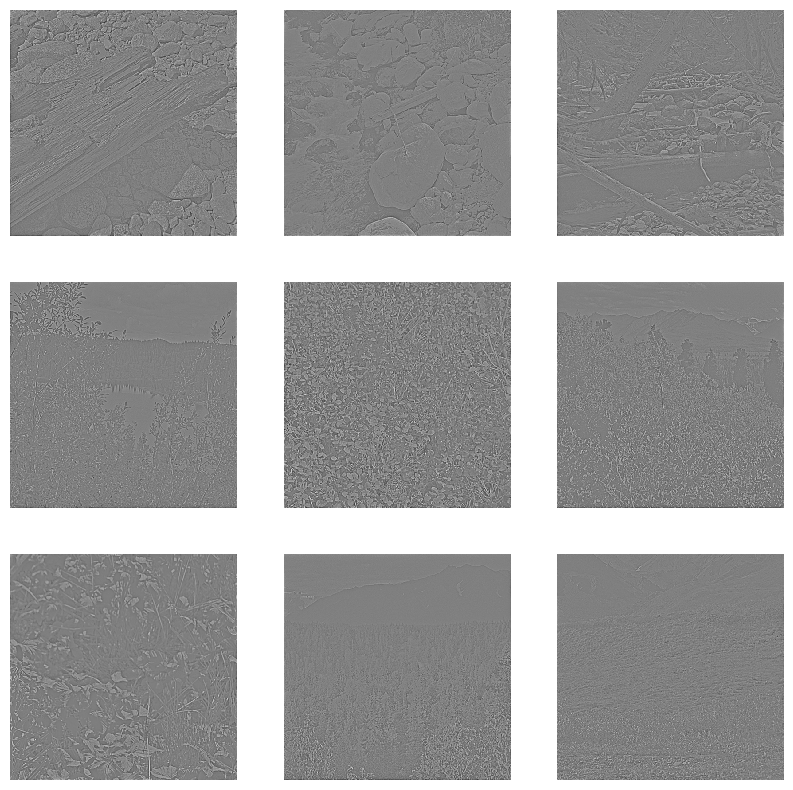

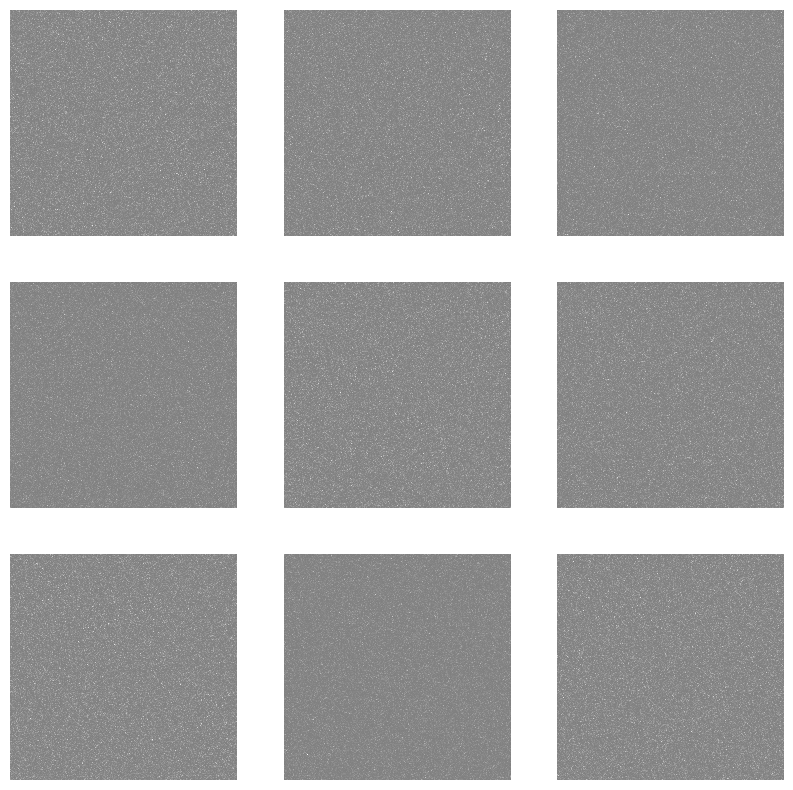

In [8]:
lab.plot_all_images(imgs["I1"])
lab.plot_all_images(imgs["I2"])
lab.plot_all_images(imgs["I2w"])
lab.plot_all_images(imgs["I3"])

<u>**Q1: Which images are natural and which were artificially generated? What do you
think the difference is between `I2` and `I2w`? How do you think
`I3` was generated?  From each dataset include a sample image in your report.**</u>

## 4. Compact coding – principal components (30 min)

In this section we will perform principle component analysis (PCA) on sets of images. First run the next cell to define necessary functions.

We can perform PCA on a set of subimages from an
image set, using

`
B, percent = lab.pca3g3(I, sz, n_sub)
`

where `I` is the image set, each subimage has size `sz` x `sz`,
and `n_sub` is the number of subimages to randomly sample from the images.
PCA is then performed on these sampled subimages and returns the matrix of
basis functions $\mathbf{B}$ (that is, the principal components) as well as the
percent of the total variance in the subimages that each of these components
capture.

### 4.1. Image set `I1`

Perform PCA on the image set `imgs["I1"]`, using `sz=16` and `n_sub=1000`. Then use
`plot_all_images` to display the first 16 basis functions. 

In [ ]:
B, percent = lab.pca3g3(imgs["I1"], 16, 1000)
lab.plot_all_images(B[0:16])

Plot the amount of variance that each basis function accounts for on a
log-log scale using

In [ ]:
plt.figure(figsize=(5,5))
plt.loglog(percent, "k")
plt.show()

<u>**Q2: How many principal components would you need to account for 90\% of the
total variance?**</u> (you may find the functions `np.cumsum` and `np.where` useful; to find out how they work, run e.g. `np.cumsum?`.)


To gain some insight into what information the various basis functions encode, one can work out the activation that a neuron responsible for a particular basis function would have, by moving over the text image and multiplying each subimage by a particular basis function.
This is equivalent to a convolution with a two-dimensional filter given by the basis function.
You can use the function `lab.overlayimages` and run:

`lab.overlayimages(image,basis_func)`

which will filter the single image with a single basis function `basis_func` to calculate the
activations. These activations are then overlaid onto the original images to
highlight the features this neuron is interested in. For example, running the next cell

In [ ]:
lab.overlayimages(imgs["I1"][0], B[0])

will display the original image, the filtered image (i.e. the activations of the basis function at different locations), the overlay of the image and the filtered image, and finally the basis function used for
filtering. Examine the activations for the first 16 or so basis functions. You
may want to write a "for loop" to do this automatically. <u>**Q3: Can you
interpret the sort of image features that some of these bases are selective
for? (You may need to zoom in on the images.) Include in your report whatever plots you find useful to support your interpretation.**</u>

### 4.2. Image set `I3`

In [ ]:
B, percent = lab.pca3g3(imgs["I3"], 16, 1000)
lab.plot_all_images(B[0:16])

Perform PCA on image set `I3` and briefly examine the first 9 basis functions. <u>**Q4: Are they interpretable? (Format your answer similar to the answer to Q3.) How many principal components
would you need to account for 90% of the variance?**</u>


### 4.3. Image set `I2`

Perform the same analysis for the images in set `I2`  for a subimage size of 16 and `nsamp=1000`.
Display the first 64 basis functions (in an $8\times 8$ grid).
<u>**Q5: Can you interpret them? (Again, format your answer similar to the answer to Q3 and Q4.)  How many principal components would you need to account for 90% of the variance?**</u>

Again look at the activations of a neuron across some of the images using

In [ ]:
lab.overlayimages(imgs["I2"][0], B[0])

for the first few basis functions, that is for $k=1,2,3,\ldots$

<u>**Q6: What sort of decomposition does PCA appear to be doing on this particular dataset?**</u>

We can ask how well the features extracted by PCA match those of visual cortex receptive fields.

<u>**Q7: What features do the basis functions share with simple cell receptive fields? What features are missing or incorrect? Is PCA a convincing model of visual cortex receptive fields?**</u>

## 5. Sparse distributed coding (45 min)

The remainder of this lab will be to determine the optimal bases for sparse
coding, examine their properties and the neuronal activations.

### 5.1. Solving for sparse coding

Given a cost on activations $H(z)=\log(1+z^2)$, the cost to be minimised for sparse coding
from Eq. (4) (of the lab handout PDF) is

\begin{equation}
\label{eq:sparsecost}
\mathcal{C}\left(\mathbf{B}, \mathbf{A}\right) = \frac{1}{K} \sum_{k=1}^K \left ( \sum_j \left[ {S}_{kj} - \sum_i {A}_{ki} \: {B}_{ij} \right]^2
  + \lambda \sum_i \log\left(1+\frac{{A}_{ki}^2}{\sigma^2}\right) \right),
\end{equation}

where $K$ is the number of image patches in $\mathbf{S}$. On the right hand side, the first sum inside the outer parentheses is the "reconstruction error", while the second sum is a penalty that encourages the sparsity of the activations ${A}_{ki}$.<br/>
(Note that the cost function above yields the average of the cost defined in Eq. (4) evaluated over $K$ subimages; to translate back to the notation of Eq. (4), drop the index $k$ above,  replace $j$, the vectorised pixel index, with $(x,y)$, and replace $B$ and $A$ with $\phi$ and $a$, respectively.)


This cost is to be minimised w.r.t. *both* the basis functions $\mathbf{B} = \{{B}_{ij} \}$
*and* the activations $\mathbf{A} = \{{A}_{ki}\}$. To perform such a minimisation, we can
use the following iterative process:


- **Step 1:** start with a random set of basis functions $\mathbf{B}$
- **Step 2:** given this (non-optimal) fixed set of basis functions, find the
 set of activations $\mathbf{A}$ that minimises the cost $\mathcal{C}$, above, now seen as a function of the $\mathbf{A}$ only
- **Step 3:** now fix these activations, and adjust the basis
functions $\mathbf{B}$ in order to minimise the cost $\mathcal{C}$, now seen as a function of the $\mathbf{B}$ only

This procedure is guaranteed to reduce the overall cost at each step, but in
general there is no guarantee that the minimum cost will be reached.


### 5.2. Step 2: finding the optimal activations given a set of basis functions (30 min)

The cost function defined above is nonlinear because $H(z)$ is
nonlinear. However, it is a smooth function, thus amenable to minimisation
using standard gradient descent techniques. Here we will use an iterative
technique that makes use of the value of the function as well as its gradient
at a given point (for a given set of $a_i$ activations). The core of the method
is already implemented for you, but you will need to fill in a
function that computes $\mathcal{C}$ and its gradient (see below).

Python will be orders of magnitude more efficient if computations are
written in vector form using NumPy arrays. For example, the reconstruction cost (first sum inside the parentheses on the right side of the equation defining 
$\mathcal{C}$ above) can be written as $\text{Tr}(\mathbf{E}\mathbf{E}^\top) / K $,  where $\mathbf{E}$ is the error matrix $\mathbf{E} = \mathbf{S}-\mathbf{AB}$ and $\text{Tr}(\mathbf{X}) = \sum_i {X}_{ii}$ is the trace of the matrix $\mathbf{X}$ (it should be straightforward to verify that $\text{Tr}(\mathbf{X}\mathbf{X}^T) = \sum_{ij} {X}_{ij}^2$). 

*First, write down a matrix expression for the gradient of $\mathcal{C}$, seen as a scalar function of matrix $\mathbf{A}$ only.* Note that we have here a scalar function of $KN$ variables (the activations $A_{ki}$), and therefore the gradient is a *matrix* of dimension $K \times N$:

\begin{equation}
\displaystyle
\frac{\partial \mathcal{C}(\mathbf{A})}{\partial \mathbf{A}} = 
\begin{bmatrix}
 \frac{\partial \mathcal{C}(\mathbf{A})}{\partial {A}_{11}}&
 \frac{\partial \mathcal{C}(\mathbf{A})}{\partial {A}_{12}}&  
 \ldots &
 \frac{\partial \mathcal{C}(\mathbf{A})}{\partial {A}_{1N}}  \\
 \frac{\partial \mathcal{C}(\mathbf{A})}{\partial {A}_{21}}& 
 \frac{\partial \mathcal{C}(\mathbf{A})}{\partial {A}_{22}}&  
 \ldots &
 \frac{\partial \mathcal{C}(\mathbf{A})}{\partial {A}_{2N}}  \\
 \vdots &
 \vdots &
 \ddots &
 \vdots \\
 \frac{\partial \mathcal{C}(\mathbf{A})}{\partial {A}_{K1}}& 
 \frac{\partial \mathcal{C}(\mathbf{A})}{\partial {A}_{K2}}&  
 \ldots &
 \frac{\partial \mathcal{C}(\mathbf{A})}{\partial {A}_{KN}}  
 \end{bmatrix}
\end{equation}

You may want to use the following identities:

\begin{equation}
\frac{\partial\, \text{Tr}(\mathbf{A} \mathbf{X}^\top)}{\partial \mathbf{X}} = \frac{\partial\, \text{Tr}(\mathbf{X} \mathbf{A}^\top)}{\partial \mathbf{X}} = \mathbf{A}
\qquad {\sf and} \qquad
\frac{\partial\, \text{Tr}(\mathbf{X} \mathbf{A} \mathbf{X}^\top)}{\partial \mathbf{X}} = \mathbf{X}\left(\mathbf{A} + \mathbf{A}^\top\right).
\end{equation}

(e.g., to convince yourself the first formula above, use $\text{Tr}(\mathbf{A} \mathbf{X}^\top) = \sum_{k,i} A_{ki}X_{ki}$, and differentiate w.r.t. a certain element of $\mathbf{X}$, etc.; see also the [Matrix Cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf).)

Fill in the functions in the next cell (i.e. write their implementation), so that given a set of activations `A`, a
set of basis functions `B`, a subimage matrix `S`, and parameters `sigma` and
`lambd` (we use `lambd`, as `lambda` is a reserved [Python keyword](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions) which is actually used below, and should not be confused with `lambd` which stands for $\lambda$), they  return the cost $\mathcal{C}$ (as well as its components: reconstruction error and sparsity penalty) and the associated
gradient $\partial \mathcal{C}/\partial \mathbf{A}$, respectively.

In [ ]:
def cost(A, B, S, lambd, sigma):
    """
    cost function
    
    Parameters
    ----------
    A: activations with shape (n_sub, n_bas)
    B: bases functions (n_bas, n_pix)
    S: matrix of image patches (n_sub, n_pix)
    lambd: weighs the importance of reconstruction error and sparsity
    sigma: activation scale hyper-parameter in the cost function
        
    Returns
    -------
    c: average cost for the image batch (thus c = err + sparsity; see next two lines)
    err: reconstruction error per batch
    sparsity: sparsity penalty per batch, including the lambd factor
    """
    # TODO:  Code up the cost function
    # don't forget the "return" keyword

In [ ]:
def dcost_A(A, B, S, lambd, sigma):
    """
    gradient of the cost function with respect to A (i.e., dC/dA)
    
    Parameters
    ----------
    A: activations with shape (n_sub, n_bas)
    B: bases functions (n_bas, n_pix)
    S: image patches (n_sub, n_pix)
    lambd: weighs the importance of reconstruction error and sparsity
    sigma: activation scale hyper-parameter in the cost function

    Returns
    -------
    dc: gradient of the cost function dC/dA
    
    """
    
    # TODO: Code up the gradient dcost/dA
    # don't forget the "return" keyword

Once you have defined `cost` and `dcost_A`, there are two tests that you should
perform to make sure your functions are correct. 

**First**, check that it is
self-consistent using `lab.grad_error` which is a function that can check whether
your cost and your gradient agree. It does this by comparing the gradient you
wrote down to the gradient calculated using a "finite difference
    approximation", for the cost function that you wrote down. (It applies the test for randomly generated `S`, `A` and `B`, using [`np.random.randn`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.randn.html), and for `sigma = 0.3` and `lambd = 0.1`.)

Now apply (in the following empty cell) `lab.grad_error` to `cost` and `cost_A` to do the consistency check (by inputing `A_or_B` as "A").

This will print the (appropriately scaled) norm of the difference divided by the norm of the sum
as an indication of accuracy.  This number should be below $10^{-5}$ or
there is an error in your function.

In [ ]:
lab.grad_error(cost, dcost_A, "A")

### 5.3. Step 3: change the basis functions given the activations (15 min)

Next we want to update the basis functions to improve the cost, keeping the
activations fixed. To do this, we need to differentiate the cost (see Sec. 5.1 above)
w.r.t. the basis functions $\phi_i$ (or the matrix $\mathbf{B}$). 

<u>**Q8: First, work out a matrix expression for the gradient**</u> of $\mathcal{C}= \text{Tr}(\mathbf{E} \mathbf{E}^\top) / K + \mathrm{const.}$, where $\mathbf{E} = \mathbf{S} - \mathbf{AB}$ (and the $\mathrm{const.}$ stands for the $\mathbf{B}$-independent sparsity term) w.r.t. the matrix of basis functions $\mathbf{B}$. 
Again, note that this gradient is a matrix the same size as $\mathbf{B}$. 

You may find the following expressions useful (here $\mathbf{P}$ and $\mathbf{Q}$ are matrices):
\begin{equation}
\frac{\partial\, \text{Tr}(\mathbf{P}^\top \mathbf{X} \mathbf{Q})}{\partial \mathbf{X}} = \mathbf{PQ}^\top
\qquad {\sf and} \qquad
\frac{\partial\, \text{Tr}(\mathbf{P}^\top \mathbf{X}^\top \mathbf{X} \mathbf{P})}{\partial \mathbf{X}} = 2\mathbf{X}\mathbf{PP}^\top.
\end{equation}

Fill in the function `dcost_B` in the next cell (i.e. write its implementation) accordingly. 

In [ ]:
def dcost_B(A, B, S, lambd, sigma):
    """
    gradient of the cost function with respect to B (i.e., dL/dB)
    
    Parameters
    ----------
    A: activations with shape (n_sub, n_bas)
    B: bases functions (n_bas, n_pix)
    S: image patches (n_sub, n_pix)
    lambd: weighs the importance of reconstruction error and sparsity
    sigma: activation scale hyper-parameter in the cost function

    Returns
    -------
    g: gradient of the cost function dL/dB
    """    
    
    # TODO: Code up the graident dcost/dB
    # don't forget the "return" keyword

To test this function, run the next cell and make sure the output is below $10^{-5}$

In [ ]:
lab.grad_error(cost, dcost_B, "B")

We will use the gradient w.r.t. $\mathbf{B}$ in a simple gradient descent procedure,
whereby in each step $\mathbf{B}$ is changed into

\begin{equation}
\mathbf{B} \leftarrow \mathbf{B} - \eta \frac{\partial \mathcal{C}}{\partial \mathbf{B}}.
\end{equation}

## 6. Finding a sparse code (35 min)

We are now ready to assemble the full algorithm to determine the sparse code
for the image sets `I3` and `I2`. The function `lab.sparseopt` in the next cell contains the majority of the code you need. The code takes as input one of the image sets
and runs for a set number of iterations which alternately optimize the
activations and basis functions, and finally returns the "optimal" basis
functions. For example,

`
B = lab.sparseopt(cost, dcost_A, dcost_B, imgs["I3"], 350)
`

will perform 350 iterations on set `I3`. (Note that the first three input arguments passed to `lab.sparseopt` are the Python functions for the cost and its gradients, which you will have written; you will not need to change these arguments here or below.) 

*Work through the code in the inner loop of `lab.sparseopt` between the lines clearly marked in the file `lab.py` to understand what it is doing. You can work through the rest of the code at write-up to make sure you understand it.*

The optimization inner loop first extracts a set of subimages $\mathbf{S}$ and then

1. compute the optimal activations `A` given the current bases `B`
and subimages `S` (see Sec. 4.2 above).


2. given these activations, optimize the matrix of basis functions `B`
by taking one step down the gradient of $\mathcal{C}$ (see Sec. 4.3 above). 
Here, you need to iterate over the subimages
`S[0]`, `S[1]`, ... and their corresponding activations
`A[0]`, `A[1]`, ... to find the gradient `dB` w.r.t. $\mathbf{B}$
for each subimage and average all the gradients out. (Note that `S[0]`, or equivalently `S[0,:]`, is the first row of `S`, etc.)

<u>**Q9: If you were to run this optimisation recipe now, the values in the basis
functions would tend to grow without bound. Why is this?**</u>

To keep $\mathbf{B}$ bounded, the basis function are in fact normalised at each iteration, in a specific way which we don't discuss here.

### Fit the sparse coding model to the `I3` dataset

In the next cell run `lab.sparseopt` on the images in `I3` for 350 iterations:

In [ ]:
img = imgs["I3"]
B, cost_hist = lab.sparseopt(cost, dcost_A, dcost_B, img, 350, lambd=0.05)

This may take some time to run. The code will display the bases every 50 steps – watch how the basis functions change over the course of the optimisation.

<u>**Q10: In what ways are these basis functions different from those obtained with PCA (compact code)? We've asked this before, but perhaps your answer has now changed: how do you think this data set `I3` was generated?**</u>

### Fit the sparse coding model to the `I2` dataset

If we were to run `lab.sparseopt` on the `I2` data set, there would be
problems as the image has very different variances along different directions in the $n_{\sf pix}$-dimensional image space (not to be confused with the 2D plane of the image!) and gradient descent methods are sensitive to this (this is a technical detail that we will not concern ourselves with). Therefore, we provide the dataset
`I2w` which is a "sphericalised", or whitened, version of `I2`, in which variances in
different directions have been equalised. 

For this data set, we will use a larger $\lambda$ (`lambd=0.2`) and consider larger image patches with dimensions 14 x 14. Now run `lab.sparseopt` on dataset `I2w` for 3000 iterations: 

In [ ]:
img = imgs["I2w"]
B, ls = lab.sparseopt(cost, dcost_A, dcost_B, img, 3000, lambd=0.2, sz=14)

<u>**Q11: In what ways are these basis functions different from those obtained with PCA? What features do they share with receptive fields of simple cells of the visual cortex?**</u>

Again, overlay some of the activations on the images to examine what these
units represent. To do this, you will want to filter `I2w` but overlay on `I2`,
so use the following (note the extra input argument to `lab.overlayimages`):

In [ ]:
#iterate over the bases B
lab.overlayimages(imgs["I2w"][0], B[1], imgs["I2"][0])

## 7. Bonus questions

The questions in this section are **bonus** questions, meaning they will give you extra marks, but you do not need to answer them to get the full mark. You can use one extra page (in addition to the 5 page limit for the rest of the report) for answering these. 

<u>**BQ1: As described above, the dataset `I2w` is a whitened version of `I2`, meaning in `I2w` variances in
different directions (in the image space) have been equalised. How would you go about performing this pre-processing step using PCA, if you were to implement it yourself?**</u>


<u>**BQ2: How can you verify whether the code (in either the `I2` or `I3` cases) is indeed sparse?**</u> (Hint: you can use the function `lab.optimal_A`.) As a first step, answer this general question: <u>**how would you inspect whether any random variable has a sparse distribution?**</u>


<u>**BQ3: How good is the reconstruction quality of the reconstructed image $\textbf{a}\textbf{B}$ (using the obtained basis functions in section 6)? Use visualisation to give a qualitative answer for some example images, but also quantify it.  (Again do this for both the `I2` and `I3` cases.)**</u>






## 8. Write up

**Write up the findings of this lab in a 5-page report (+1 page for bonus questions); discuss your interpretation of the results.**
**Suggest any further simulations that would be interesting to perform. You are also encouraged to comment on any aspects of the lab in the report.**


**Please do make sure that your report contains answers to all the underlined sections in this handout
which are marked by Q1, Q2, etc. – these require specific answers /discussion. Please start your answers to these 
by (ideally boldface) A1:, A2:, etc, and mark the answer's end by the acronym EOA (again in boldface). Similarly start answers to any of the bonus questions with BA1:, BA2:, etc.** Note that your answers need not appear in your report in the same order as the questions were asked in the notebook ─ it is up to you to organise your report so that it flows well.


**Note, however, that the report should include more than these answers: it should include an introduction/background section (which can borrow efficiently and selectively from the lab handout), a results/methods section (the bulk of the report) with various plots (certainly those that you were instructed to include in the report, but also any others that you plotted on your own and you deem relevant to the narrative), and a conclusion section. It should also include the Python code for the functions you had to write (perhaps in an appendix). Given space, you may e.g. consider reproducing a couple of key figures from the lab handout too (e.g. in the Intro), in order to make the report as self-contained as possible, and give it a coherent flow. Including all of the above in 5 pages (+1 for answers to bonus Q's) is challenging, but a main point of writing the report is to practice and learn writing in a concise style and prioritising important information vs. relatively irrelevant detail. So consider carefully what you need to show to give a coherent account of what you have done and what you have learned, vs. what constitutes details that need not much expanding (or inclusion).**

**To submit the report on Moodle, it has to be formatted as a PDF file. Also save the final state of your Jupyter notebook as a PDF and collate the report and notebook PDF's (in that order) into one file which you will submit on Moodle. The "print-out" of (the final state of) your notebook will only serve as proof of work, and will not be marked.**
